In [134]:
import pandas as pd
from neo4j import GraphDatabase
import time

In [135]:
start_node = 'Devices'
end_node = 'Devices'
auth_event_edge = 'AuthEvents'
host_event_edge = 'HostEvents'

In [136]:
events_data = {
4768 : 'Kerberos authentication ticket was requested (TGT)',
4769 : 'Kerberos service ticket was requested (TGS)',
4770 : 'Kerberos service ticket was renewed',
4774 : 'An account was mapped for logon',
4776 : 'Domain controller attempted to validate credentials',
4624 : 'An account successfully logged on, see Logon Types',
4625 : 'An account failed to logon, see Logon Types',
4634 : 'An account was logged off, see Logon Types',
4647 : 'User initiated logoff',
4648 : 'A logon was attempted using explicit credentials',
4672 : 'Special privileges assigned to a new logon',
4800 : 'The workstation was locked',
4801 : 'The workstation was unlocked',
4802 : 'The screensaver was invoked',
4803 : 'The screensaver was dismissed',
4688 : 'Process start',
4689 : 'Process end',
4608 : 'Windows is starting up',
4609 : 'Windows is shutting down',
1100 : 'Event logging service has shut down'
}


In [137]:
event_ids = events_data.keys()
id_description = events_data.values()
df_events = pd.DataFrame(list(zip(event_ids, id_description)), 
               columns =['event_id', 'description']) 

In [138]:
logon_types_description = {
2 : 'Interactive',
5 : 'Service',
9 : 'New Credentials',
3 : 'Network', 
7 : 'Unlock', 
10 : 'Remote Interactive',
4 : 'Batch', 
8 : 'Network Clear Text', 
11 : 'Cached Interactive',
12 : 'Cached Remote-Interactive',
0 : 'Used only by the system account'
}

In [139]:
logons = logon_types_description.keys()
logon_description = logon_types_description.values()
df_logons = pd.DataFrame(list(zip(logons, logon_description)), 
               columns =['logon_type', 'description']) 

In [140]:
# Get Connection to neo4j

uri = 'bolt://localhost:7687'
username = 'neo4j'
password = 'graph'

neo4j_driver = GraphDatabase.driver(uri, auth=(username,password))

In [141]:
%%time
q = """
MATCH (n0:{0})-[r:{2}]->(n1:{1})
RETURN count(r.event_id) as frequency, r.event_id as event_id
ORDER BY frequency DESC
""".format(start_node, end_node, auth_event_edge)

with neo4j_driver.session() as neo4j_Session:
    result = neo4j_Session.run(q)
    answer = result.data()

df1 = pd.DataFrame(answer)

CPU times: user 7.91 ms, sys: 965 µs, total: 8.87 ms
Wall time: 1min 16s


In [142]:
%%time
q = """
MATCH (n0:{0})-[r:{2}]->(n1:{1})
RETURN count(r.event_id) as frequency, r.event_id as event_id
ORDER BY frequency DESC
""".format(start_node, end_node, host_event_edge)

with neo4j_driver.session() as neo4j_Session:
    result = neo4j_Session.run(q)
    answer = result.data()

df2 = pd.DataFrame(answer)
df1 = df1.append(df2,ignore_index=True)
df1.sort_values(by=['frequency'],inplace=True, ascending=False)
df1.head()

CPU times: user 8.87 ms, sys: 4.26 ms, total: 13.1 ms
Wall time: 38.1 s


,frequency,event_id
11,18527129,4688
0,16389671,4624
1,15950203,4634
2,5572526,4672
3,5354657,4776


In [143]:
pd.set_option('display.max_colwidth', None)
df_event_description = pd.merge(df1, df_events, how='inner', on='event_id')
df_event_description

,frequency,event_id,description
0,18527129,4688,Process start
1,16389671,4624,"An account successfully logged on, see Logon Types"
2,15950203,4634,"An account was logged off, see Logon Types"
3,5572526,4672,Special privileges assigned to a new logon
4,5354657,4776,Domain controller attempted to validate credentials
5,2271788,4769,Kerberos service ticket was requested (TGS)
6,1013302,4648,A logon was attempted using explicit credentials
7,875992,4768,Kerberos authentication ticket was requested (TGT)
8,332510,4625,"An account failed to logon, see Logon Types"
9,38290,4800,The workstation was locked


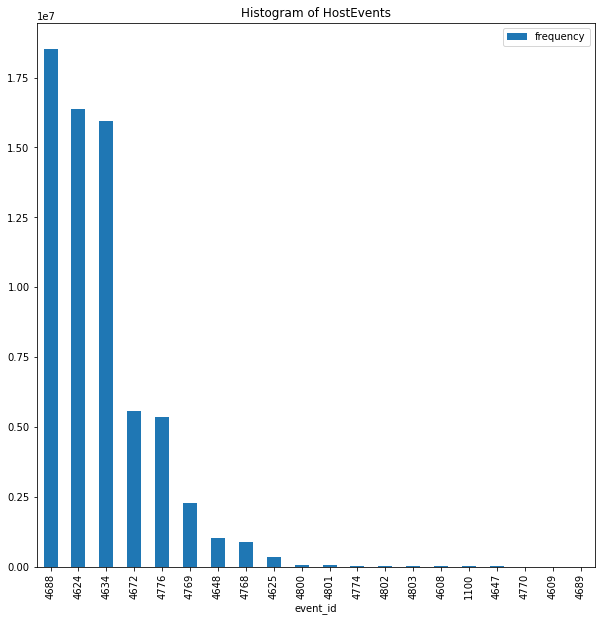

In [144]:
df1.plot.bar(x='event_id',y='frequency',figsize=(10,10), title='Histogram of HostEvents')

In [145]:
%%time
q = """
MATCH (n0:{0})-[r:{2}]->(n1:{1})
RETURN count(r.logon_type) as frequency, r.logon_type as logon_type
ORDER BY frequency DESC
""".format(start_node, end_node, auth_event_edge)

with neo4j_driver.session() as neo4j_Session:
    result = neo4j_Session.run(q)
    answer = result.data()

df3 = pd.DataFrame(answer)
df3.head()

CPU times: user 10.2 ms, sys: 1.8 ms, total: 12 ms
Wall time: 1min 28s


,frequency,logon_type
0,31961748,3
1,15124150,0
2,226616,5
3,191829,2
4,170955,7


In [146]:
df_logon_description = pd.merge(df3, df_logons, how='inner', on='logon_type')
df_logon_description

,frequency,logon_type,description
0,31961748,3,Network
1,15124150,0,Used only by the system account
2,226616,5,Service
3,191829,2,Interactive
4,170955,7,Unlock
5,95692,8,Network Clear Text
6,7390,4,Batch
7,5477,11,Cached Interactive
8,3324,10,Remote Interactive
9,2864,9,New Credentials


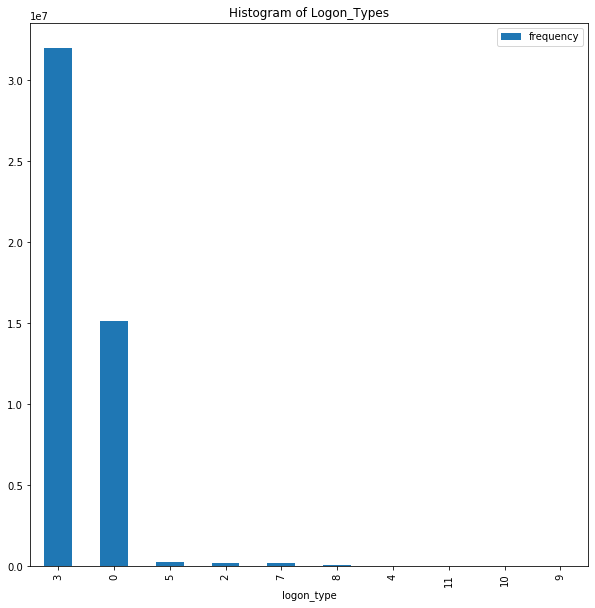

In [147]:
df3.plot.bar(x='logon_type',y='frequency',figsize=(10,10), title='Histogram of Logon_Types')

In [148]:
%%time
q = """
MATCH (n0:{0})-[r:{2}]->(n1:{1})
RETURN count(DISTINCT r.log_host) as frequency_log_host,
       count(DISTINCT r.user_name) as frequency_user_name,
       count(DISTINCT r.src) as frequency_src,
       count(DISTINCT r.process_name) as frequency_process_name
""".format(start_node, end_node, auth_event_edge)

with neo4j_driver.session() as neo4j_Session:
    result = neo4j_Session.run(q)
    answer = result.data()

df4 = pd.DataFrame(answer)
df4.head()

CPU times: user 23.7 ms, sys: 4.45 ms, total: 28.1 ms
Wall time: 3min 12s


,frequency_log_host,frequency_user_name,frequency_src,frequency_process_name
0,10323,21075,0,100


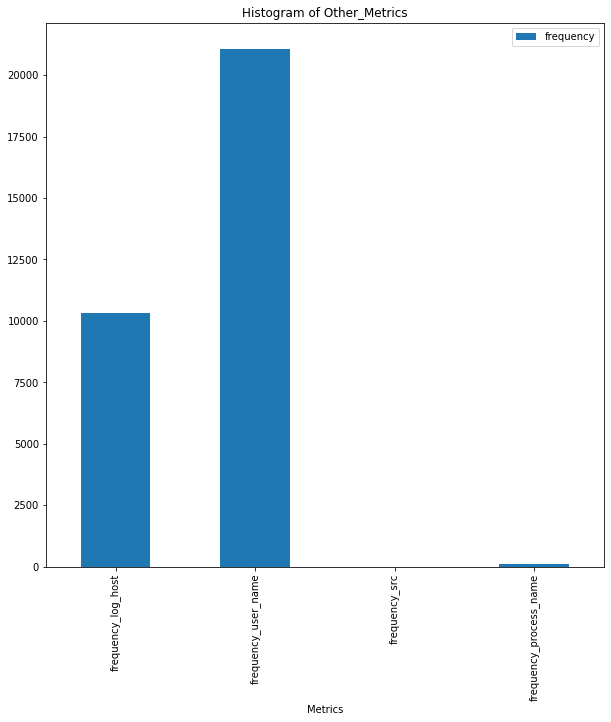

In [149]:
df5 = df4.T
df5['Metrics'] = df5.index
df5.rename(columns={0:'frequency'}, inplace=True)
df5.plot.bar(x='Metrics', y='frequency', figsize=(10,10), title='Histogram of Other_Metrics')